In [1]:
######## Imports ########
import numpy as np
import pandas as pd
import sys

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##########################

root_logdir = "./tf_logs"
datadir = "data/"
figures_dir = "data/figures/"

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

np.random.seed(seed=42)

from helper import *

# To plot pretty figures
%matplotlib widget

## Half the data will be split out as validation and 0.2 as the test set

In [2]:

def get_split_index(features, labels, test_size=0.2):
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, original_labels, training_labels):
    train_index, validation_index = get_split_index(features, original_labels, test_size=0.5)[0]
    
    X_valid, y_valid, y_valid_original = features.iloc[validation_index],  training_labels.iloc[validation_index], original_labels.iloc[validation_index]
    X_train, y_train, y_original = features.iloc[train_index], training_labels.iloc[train_index], original_labels.iloc[train_index]
     
    return X_train, y_train, y_original, X_valid, y_valid, y_valid_original

def get_train_test_val(features, original_labels, training_labels):
    
    X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(features,original_labels, training_labels)
   
    train_index, test_index = get_split_index(X, y_original)[0]
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    return X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original

### Train a DNN on the modified dataset

Creating data...
Plotting blobs...
Calling DF's plot...
Showing plot...


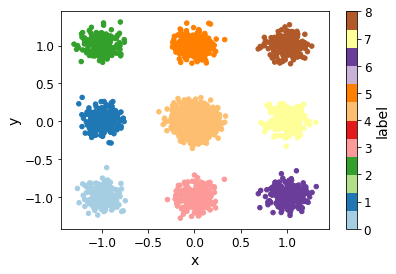

Train Size: (1600, 2)
Test Size: (400,)
Categories: [array([0, 1])]


In [3]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=2000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [4]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [5]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
#     keras.backend.clear_session()
    import tensorflow as tf
    import keras
    
    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, epochs=30, batch_size=20, verbose=0):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    y_train = hot_encoder.transform(y)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=verbose)
    
    return history, ZScaler


In [6]:
from multiprocessing import Pool

def runDNN(depth, epochs=50):
    import innvestigate
    import innvestigate.utils as iutils
    
    nn = build_dnn(NUM_FEATURES)
    history, ZScaler = train_model(nn, X_train, y_train, 
                                   epochs=epochs, batch_size=20)
    
    
    scaled_samples = ZScaler.transform(X_valid)
    final_acc = nn.evaluate(scaled_samples,hot_encoder.transform(y_valid), verbose=0)

    # Getting all the samples that can be correctly predicted
    all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
    lrp_labels = y_valid_original[correct_idxs]


    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = perform_analysis(model,lrp_E, all_samples)
    print("Finished training depth: {}, epochs: {} ".format(depth,epochs))
    return (final_acc, lrp_results, lrp_labels)

In [7]:
depth_epochs = {2:50,3:50,4:50,5:100}
print("Starting pool execution...")
pool = Pool(processes = 4)

results = pool.starmap(runDNN, [(depth,epoch) for depth,epoch in depth_epochs.items()])
# if __name__ == '__main__':
#     results = pool.map(runDNN, [d for d in depth_epochs] )

# pool.close()
# pool.join()
print("Done training DNNs")

# print(results)

Starting pool execution...


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


NameError: name 'keras' is not defined